In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
#import random 
import scipy.integrate as spi
from scipy.integrate import solve_ivp
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from scipy.integrate import odeint

#for plotting
from numpy import loadtxt
from pylab import figure, plot, xlabel, grid, legend, title, savefig
from matplotlib.font_manager import FontProperties
import warnings

In [2]:
%matplotlib inline
#pd.set_option('display.max_rows', None)
#suppress warnings
warnings.filterwarnings('ignore')

In [3]:
#diameter of the source is 0.35 inch = 0.886 cm -> radius = 0.445 cm = 0.00445 m

#number of simulation n
n=1e7;
n=int(n)
#length of Quad = 50.45*2.54/100;
L=50.45*2.54/100;
L

1.28143

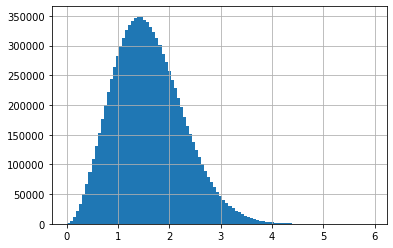

In [4]:
#creating  maxwell distribution
from scipy.stats import maxwell
r_maxwell = maxwell.rvs(size=n);
plt.hist(r_maxwell,100);
plt.grid()

In [5]:
#using cartesian co-ordinate
x0 = np.random.uniform(-0.00445, 0.00445,n);#assuming x max and y max to be 0.445 cm
y0 = np.random.uniform(-0.00445, 0.00445,n);
z0 = 0;
rand1p=np.random.uniform(0,1,n);
rand1=np.sqrt(rand1p)
rand2p=np.random.uniform(0,1,n);
rand2=np.sqrt(rand2p)
#binary 
p1=np.random.choice([-1,1], n) 
p2=np.random.choice([-1,1], n) 

In [6]:
theta = np.arcsin(rand1)
#theta = np.sqrt(thetap)
theta1 = np.arcsin(rand2)
#theta1=np.sqrt(theta1p)

phi=np.pi*rand2
np.arcsin(1)
#print(theta)
#print(thetap)
#print(theta1)
#print(theta1p)
#plt.hist(theta,100);

1.5707963267948966

In [7]:
m_He=3*1.67*10**(-27)
kB=1.38*10**(-23)
T=1.3

In [8]:
# velocity of the Helium3
#most probale velocity of the particle in molecular beam is given by 1.22 * alpha:
#alpha = sqrt(2*kB*T/m_He)
v0 = math.sqrt(3*kB*T/m_He)
v0

103.64610446157577

In [9]:
v=v0 * r_maxwell
dframe=pd.DataFrame({'x0':x0,'y0':y0,'theta':theta, 'theta1':theta1,'v':v})
dframe['vx']=(1-np.cos(dframe['theta']))*v
dframe['vy']=(1-np.cos(dframe['theta1']))*v
dframe['vz']=(dframe['v']**2-dframe['vx']**2-dframe['vy'])**0.5
dframe['p1']=p1
dframe['p2']=p2
vx=v0*(1-np.cos(theta))
vy=v0*(1-np.cos(theta1))

vz_sq= (v**2-vx**2-vy**2)

mask = (vz_sq > 0) 
# make vz=0 for those events which will have (vx^2 + vy^2)^0.5 > vz

vz = 0+ mask*(vz_sq)**0.5
#mask
print(vx)
print(vy)
dframe

[20.3611931  85.06230649 14.26089042 ... 28.52884271 49.18321992
 17.41553626]
[35.37125529 10.064478    7.02270559 ... 11.97143514 77.82802132
 32.81794612]


,x0,y0,theta,theta1,v,vx,vy,vz,p1,p2
0,0.000977,-0.004076,0.637560,0.851666,352.877918,69.322581,120.426474,345.827672,1,-1
1,0.000056,-0.000954,1.390521,0.444337,205.371323,168.548143,19.942430,117.255966,-1,1
2,0.000077,0.002707,0.530789,0.370232,137.393219,18.904228,9.309295,136.052260,-1,-1
3,0.002990,-0.001774,0.711583,0.795103,147.416116,35.773627,44.193727,142.855049,-1,1
4,0.004291,0.001756,0.321689,0.858999,223.475744,11.463695,77.502376,223.007824,-1,-1
...,...,...,...,...,...,...,...,...,...,...
9999995,-0.000659,-0.002011,0.258641,0.378143,97.512981,3.243423,6.889130,97.423675,-1,-1
9999996,0.000161,0.000314,1.079771,0.282285,21.361588,11.288950,0.845461,18.111642,1,-1
9999997,0.001548,-0.003827,0.760128,0.485382,254.431363,70.032852,29.387584,244.543106,-1,-1
9999998,0.001403,-0.002008,1.017529,1.319047,146.532829,69.534271,110.031730,128.556693,-1,1


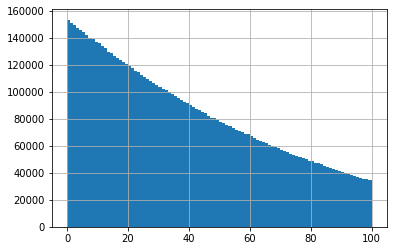

In [10]:
plt.hist(dframe['vx'],100,range=[0,100]);
plt.grid()

In [11]:
df=pd.DataFrame({'x0':dframe['x0'],'y0':dframe['y0'],'z0':z0, 'vx':dframe['vx']*dframe['p1'], 'vy':dframe['vy']*dframe['p2'], 'vz':dframe['vz']})
df

,x0,y0,z0,vx,vy,vz
0,0.000977,-0.004076,0,69.322581,-120.426474,345.827672
1,0.000056,-0.000954,0,-168.548143,19.942430,117.255966
2,0.000077,0.002707,0,-18.904228,-9.309295,136.052260
3,0.002990,-0.001774,0,-35.773627,44.193727,142.855049
4,0.004291,0.001756,0,-11.463695,-77.502376,223.007824
...,...,...,...,...,...,...
9999995,-0.000659,-0.002011,0,-3.243423,-6.889130,97.423675
9999996,0.000161,0.000314,0,11.288950,-0.845461,18.111642
9999997,0.001548,-0.003827,0,-70.032852,-29.387584,244.543106
9999998,0.001403,-0.002008,0,-69.534271,110.031730,128.556693


Calculate the time for the beam to reach the circular opening

In [12]:
# first circle of radius 0.2677/2 inch = 0.339979 cm is at z=5.65847484 cm
# calculate time to travel this distance
df ['t'] = 0.0565847484/df ['vz'];
# second circle of radius 0.2677/2 inch = 0.339979 cm is at z=16.65667484 cm
df['t_2'] = 0.1665667484/df['vz']
#the quad start at z = 23.32167294 cm
df['t_3'] = 0.2332167294/df['vz']
#Quad end at z = 1.5332167294/df['vz']
#df['t_f'] = 1.5332167294 / df['vz']
df


,x0,y0,z0,vx,vy,vz,t,t_2,t_3
0,0.000977,-0.004076,0,69.322581,-120.426474,345.827672,0.000164,0.000482,0.000674
1,0.000056,-0.000954,0,-168.548143,19.942430,117.255966,0.000483,0.001421,0.001989
2,0.000077,0.002707,0,-18.904228,-9.309295,136.052260,0.000416,0.001224,0.001714
3,0.002990,-0.001774,0,-35.773627,44.193727,142.855049,0.000396,0.001166,0.001633
4,0.004291,0.001756,0,-11.463695,-77.502376,223.007824,0.000254,0.000747,0.001046
...,...,...,...,...,...,...,...,...,...
9999995,-0.000659,-0.002011,0,-3.243423,-6.889130,97.423675,0.000581,0.001710,0.002394
9999996,0.000161,0.000314,0,11.288950,-0.845461,18.111642,0.003124,0.009197,0.012877
9999997,0.001548,-0.003827,0,-70.032852,-29.387584,244.543106,0.000231,0.000681,0.000954
9999998,0.001403,-0.002008,0,-69.534271,110.031730,128.556693,0.000440,0.001296,0.001814


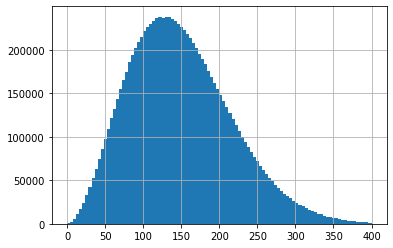

In [13]:
df['x_1']=df['x0']+df['vx']*df['t']
df['y_1']=df['y0']+df['vy']*df['t']
df['r_1']=(df['x_1']**2+df['y_1']**2)**0.5
df
plt.hist(df['vz'],100,range=[0,400]);
plt.grid()

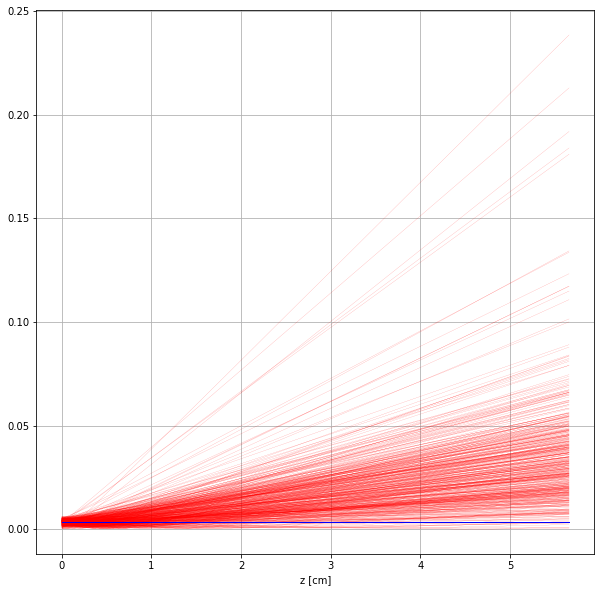

In [14]:
h_h=0;
for index, row in df.iterrows():
    if index >=500:
        break   
    stoptime=row['t']
    numpoints = 50

    #print(numpoints)
    t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]
    #print (t[0])
    #print(row['y_f'])
    Y_hi=[]
    X_hi=[]
    R_hi=[]
    Z_hi=[]
    Mask=[]
    for h_h in range(numpoints):
        #print (h_1)
        y_hi=(row['y0']+row['vy']*t[h_h])
        x_hi=(row['x0']+row['vx']*t[h_h])
        z_hi=row['vz']*t[h_h]*100
        r_hi=(y_hi**2+x_hi**2)**0.5
        #print(y_h)
        Y_hi.append(y_hi)
        X_hi.append(y_hi)
        R_hi.append(r_hi)
        Z_hi.append(z_hi)
        Mask.append(0.00339979)
    #x_new=row['x_f']
    #vx_new=row['vx']
    #vy_new=row['vy']
    
    
    figure(3, figsize=(10, 10))
    xlabel('z [cm]')
    grid(True)
    #hold(True)
    lw = 0.1
    #plot(t, x1, 'b', linewidth=lw)
    #plot(t, x2, 'g', linewidth=lw)
    #plot(t, Y_h, 'b', linewidth=lw)
    #plot(t, X_h, 'b', linewidth=lw)
    plot(Z_hi, R_hi, 'r', linewidth=lw)
    plot(Z_hi, Mask, 'b', linewidth=1.0)

In [15]:
#first circle of radius 0.2677/2 inch = 0.339979 cm

In [16]:
df1 = df.loc[(df['r_1'] < 0.00339979 )]
df1=df1.reset_index(drop=True)
df1

,x0,y0,z0,vx,vy,vz,t,t_2,t_3,x_1,y_1,r_1
0,-0.000405,0.003705,0,3.367009,-12.839350,128.613510,0.000440,0.001295,0.001813,0.001077,-0.001944,0.002222
1,0.001062,-0.002316,0,1.405068,8.390077,100.847688,0.000561,0.001652,0.002313,0.001851,0.002391,0.003024
2,-0.001579,0.000759,0,9.142177,-10.084120,172.779210,0.000327,0.000964,0.001350,0.001415,-0.002543,0.002910
3,-0.000276,-0.001131,0,-1.960698,3.705692,246.615343,0.000229,0.000675,0.000946,-0.000726,-0.000281,0.000779
4,-0.001737,-0.000331,0,7.436396,1.290836,200.840974,0.000282,0.000829,0.001161,0.000358,0.000033,0.000359
...,...,...,...,...,...,...,...,...,...,...,...,...
102646,-0.002004,-0.000833,0,12.278950,1.661594,272.442289,0.000208,0.000611,0.000856,0.000546,-0.000488,0.000732
102647,-0.001588,-0.001634,0,-1.413114,5.605059,144.582913,0.000391,0.001152,0.001613,-0.002141,0.000560,0.002213
102648,0.000110,-0.003639,0,-6.030560,21.173873,208.361671,0.000272,0.000799,0.001119,-0.001527,0.002112,0.002606
102649,0.004024,0.000861,0,-4.414491,2.298167,80.909707,0.000699,0.002059,0.002882,0.000936,0.002469,0.002640


In [17]:
df1['x_2']=df1['x0']+df1['vx']*df1['t_2']
df1['y_2']=df1['y0']+df1['vy']*df1['t_2']
df1['r_2']=(df1['x_2']**2+df1['y_2']**2)**0.5
df1

,x0,y0,z0,vx,vy,vz,t,t_2,t_3,x_1,y_1,r_1,x_2,y_2,r_2
0,-0.000405,0.003705,0,3.367009,-12.839350,128.613510,0.000440,0.001295,0.001813,0.001077,-0.001944,0.002222,0.003956,-0.012924,0.013515
1,0.001062,-0.002316,0,1.405068,8.390077,100.847688,0.000561,0.001652,0.002313,0.001851,0.002391,0.003024,0.003383,0.011541,0.012027
2,-0.001579,0.000759,0,9.142177,-10.084120,172.779210,0.000327,0.000964,0.001350,0.001415,-0.002543,0.002910,0.007235,-0.008962,0.011518
3,-0.000276,-0.001131,0,-1.960698,3.705692,246.615343,0.000229,0.000675,0.000946,-0.000726,-0.000281,0.000779,-0.001601,0.001371,0.002108
4,-0.001737,-0.000331,0,7.436396,1.290836,200.840974,0.000282,0.000829,0.001161,0.000358,0.000033,0.000359,0.004430,0.000740,0.004491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102646,-0.002004,-0.000833,0,12.278950,1.661594,272.442289,0.000208,0.000611,0.000856,0.000546,-0.000488,0.000732,0.005503,0.000183,0.005506
102647,-0.001588,-0.001634,0,-1.413114,5.605059,144.582913,0.000391,0.001152,0.001613,-0.002141,0.000560,0.002213,-0.003216,0.004823,0.005797
102648,0.000110,-0.003639,0,-6.030560,21.173873,208.361671,0.000272,0.000799,0.001119,-0.001527,0.002112,0.002606,-0.004711,0.013288,0.014098
102649,0.004024,0.000861,0,-4.414491,2.298167,80.909707,0.000699,0.002059,0.002882,0.000936,0.002469,0.002640,-0.005064,0.005593,0.007545


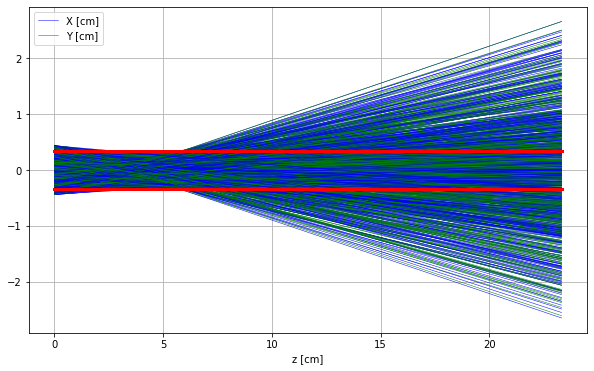

In [18]:
h_a=0;
for index, row in df1.iterrows():
    if index >=500:
        break   
    stoptime=row['t_3']
    numpoints = 50

    #print(numpoints)
    t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]
    #print (t[0])
    #print(row['y_f'])
    Y_him=[]
    X_him=[]
    R_him=[]
    Z_him=[]
    Mask_h=[]
    Mask_k=[]
    for h_a in range(numpoints):
        #print (h_1)
        y_him=(row['y0']+row['vy']*t[h_a])*100
        x_him=(row['x0']+row['vx']*t[h_a])*100
        z_him=row['vz']*t[h_a]*100
        r_him=(y_him**2+x_him**2)**0.5
        #print(y_h)
        Y_him.append(y_him)
        X_him.append(x_him)
        R_him.append(r_him)
        Z_him.append(z_him)
        Mask_h.append(0.339979)
        Mask_k.append(-0.339979)
    #x_new=row['x_f']
    #vx_new=row['vx']
    #vy_new=row['vy']
    
    
    figure(3, figsize=(10, 6))
    xlabel('z [cm]')
    grid(True)
    #hold(True)
    lw = 0.5
    #plot(t, x1, 'b', linewidth=lw)
    #plot(t, x2, 'g', linewidth=lw)
    #plot(t, Y_h, 'b', linewidth=lw)
    plot(Z_him, X_him, 'b', linewidth=lw)
    #plot(Z_him, R_him, 'r', linewidth=lw)
    plot(Z_him, Y_him, 'g', linewidth=lw)
    plot(Z_him, Mask_h, 'r', linewidth=3)
    plot(Z_him, Mask_k, 'r', linewidth=3)
    plt.legend(["X [cm]", "Y [cm]"])

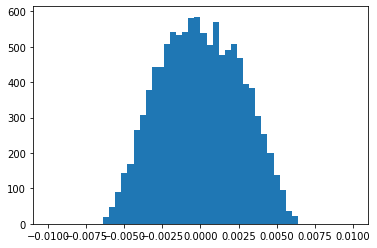

In [19]:
# Lets cut those who have greater radius than 10 m (large ring in a aparatus)
df2 = df1.loc[(df1['r_2'] < 0.00339979 )]
df2=df2.reset_index(drop=True)
#df2
plt.hist(df2['x0']+df2['vx']*df2['t_3'],50,range=(-0.01,0.01));

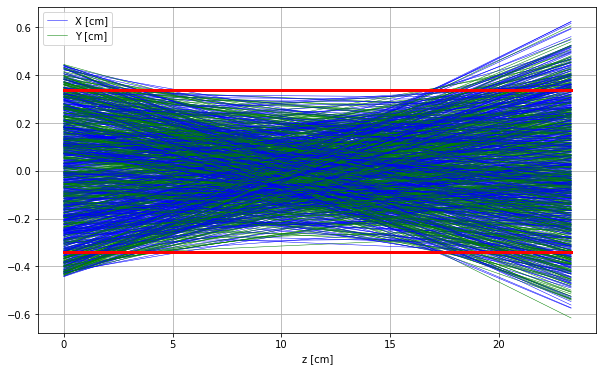

In [20]:
h_p=0;
for index, row in df2.iterrows():
    if index >=500:
        break   
    stoptime=row['t_3']
    numpoints = 50

    #print(numpoints)
    t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]
    #print (t[0])
    #print(row['y_f'])
    Y_p=[]
    X_p=[]
    R_p=[]
    Z_p=[]
    Mask_hp=[]
    Mask_kp=[]
    for h_p in range(numpoints):
        #print (h_1)
        y_p=(row['y0']+row['vy']*t[h_p])*100
        x_p=(row['x0']+row['vx']*t[h_p])*100
        z_p=row['vz']*t[h_p]*100
        r_p=(y_p**2+x_p**2)**0.5
        #print(y_h)
        Y_p.append(y_p)
        X_p.append(x_p)
        R_p.append(r_p)
        Z_p.append(z_p)
        Mask_hp.append(0.339979)
        Mask_kp.append(-0.339979)
    #x_new=row['x_f']
    #vx_new=row['vx']
    #vy_new=row['vy']
    
    
    figure(3, figsize=(10, 6))
    xlabel('z [cm]')
    grid(True)
    #hold(True)
    lw = 0.5
    #plot(t, x1, 'b', linewidth=lw)
    #plot(t, x2, 'g', linewidth=lw)
    #plot(t, Y_h, 'b', linewidth=lw)
    plot(Z_p, X_p, 'b', linewidth=lw)
    #plot(Z_him, R_him, 'r', linewidth=lw)
    plot(Z_p, Y_p, 'g', linewidth=lw)
    plot(Z_p, Mask_hp, 'r', linewidth=3)
    plot(Z_p, Mask_kp, 'r', linewidth=3)
    plt.legend(["X [cm]", "Y [cm]"])

In [21]:
df2['x_3']=df2['x0']+df2['vx']*df2['t_3']
df2['y_3']=df2['y0']+df2['vy']*df2['t_3']
df2['r_3']=(df2['x_3']**2+df2['y_3']**2)**0.5
df2['t_f']=L/df2['vz']
df2

,x0,y0,z0,vx,vy,vz,t,t_2,t_3,x_1,y_1,r_1,x_2,y_2,r_2,x_3,y_3,r_3,t_f
0,-0.000276,-0.001131,0,-1.960698,3.705692,246.615343,0.000229,0.000675,0.000946,-0.000726,-0.000281,0.000779,-0.001601,0.001371,0.002108,-0.002131,0.002373,0.003189,0.005196
1,-0.002632,0.001950,0,4.932847,-4.801447,187.993274,0.000301,0.000886,0.001241,-0.001147,0.000505,0.001253,0.001739,-0.002304,0.002887,0.003488,-0.004007,0.005312,0.006816
2,0.003498,0.002760,0,-3.217596,-2.895390,165.080017,0.000343,0.001009,0.001413,0.002396,0.001767,0.002977,0.000252,-0.000162,0.000299,-0.001047,-0.001331,0.001693,0.007762
3,-0.001064,0.001236,0,1.134986,0.336000,65.236300,0.000867,0.002553,0.003575,-0.000080,0.001528,0.001530,0.001834,0.002094,0.002784,0.002993,0.002437,0.003860,0.019643
4,-0.000472,-0.000805,0,-0.255684,0.159045,192.469362,0.000294,0.000865,0.001212,-0.000547,-0.000758,0.000935,-0.000693,-0.000667,0.000962,-0.000782,-0.000612,0.000993,0.006658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10983,-0.003141,-0.000711,0,2.309700,-0.495584,201.037673,0.000281,0.000829,0.001160,-0.002490,-0.000850,0.002632,-0.001227,-0.001121,0.001662,-0.000461,-0.001286,0.001366,0.006374
10984,-0.003327,-0.001466,0,4.839659,3.974774,205.618963,0.000275,0.000810,0.001134,-0.001995,-0.000372,0.002029,0.000594,0.001754,0.001852,0.002163,0.003042,0.003733,0.006232
10985,-0.003173,-0.001145,0,1.013647,0.080040,135.635764,0.000417,0.001228,0.001719,-0.002750,-0.001112,0.002966,-0.001928,-0.001047,0.002194,-0.001430,-0.001008,0.001749,0.009448
10986,0.004155,-0.000537,0,-2.586620,-1.657576,120.931550,0.000468,0.001377,0.001929,0.002945,-0.001313,0.003224,0.000592,-0.002820,0.002882,-0.000833,-0.003734,0.003826,0.010596


In [22]:
#start simulation inside Quad:
#Length of the quad is 1.3 m;
#Nuclear magneton mu_N=5.051*10^-27;
mu_N=5.051*10**-27;
#magnetic moment of He3 is -2.2905*mu_N;
mu_n=-2.2905*mu_N;
#length of Quad = 50.45*2.54/100;
L=50.45*2.54/100;
#mass of proton, m_p = 1.67*10^-27 kg
m_p = 1.672621 * 10**-27;
m_n = 1.67493  * 10**-27;
#Diffrential equation constant K = mu_n * Qxy/(m_He3)
#Qxy is the gradient of the quardupole magnet 
Qxy=100;
k = mu_n * Qxy /(2*m_p + m_n)
#for the easier solution I choose K = -K 
K=-k
K

230.45655607019046

The solution of the differential equation for the spin states parallel is given by:<br>




In [23]:
#xo is x_3; beam position at the begining of the Quad
#df2['x_f'] = df2['x_3'] * np.sqrt(K) * np.cos ( np.sqrt(K)*(df2['t_f']-df2['t_3']) /np.sqrt(df2['x_3']**2 + df2['y_3']**2))
#df2

In [24]:
def vectorfield(w, t, k):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2]
        t :  time
        k :  vector of the parameters:
                  k = [k1 or k2]
    """
    x1, y1, x2, y2 = w

    # Create f = (x1',y1',x2',y2'):
    f = [y1,
         -k*x1/(x1**2+x2**2)**0.5,
         y2,
         -k*x2/(x1**2+x2**2)**0.5]
    return f

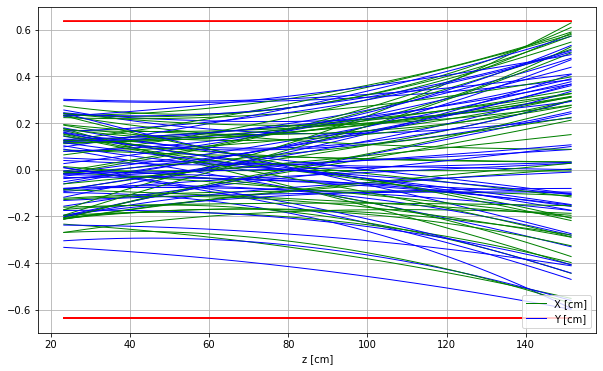

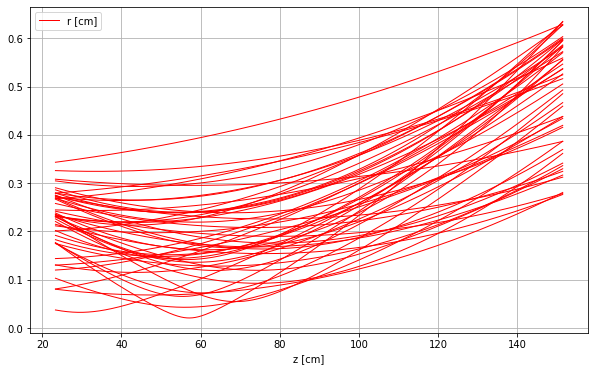

In [25]:
#Now solving the differential equation to get the trajectory inside Quad
#time of travel is (t_f-t-t_2-t_3)
DF = pd.DataFrame(columns=['x_f', 'vx_f', 'y_f','vy_f','vz_f'])
count=0
for index, row in df2.iterrows():
    if count >=500:
        break   
    #count = count+1 for crosscheck
    # Parameter values
    # modified spring constants
    k1 = K; #for spin parallel
    k2 = -K; # for anaother spin state
    # Initial conditions
    # x1 and x2 are the initial displacements; y1 and y2 are the initial velocities
    x1 = row['x_3']
    x2 = row['y_3']
    y1 = row['vx']
    y2 = row['vy']
    y3 = row['vz']
    mas = 0.00635 #diameter of the cylinder = 0.5 inch
    #print(x1,x2,y1,y2)
    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6
    stoptime = row['t_f']
    numpoints = 2500
    t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]

    # Pack up the parameters and initial conditions:
    p = k2
    w0 = [x1, y1, x2, y2]

    # Call the ODE solver.
    wsol = odeint(vectorfield, w0, t, args=(p,),
                  atol=abserr, rtol=relerr)
    X=wsol[-1]
    columns=['x_f', 'vx_f', 'y_f','vy_f']
    DFX = pd.DataFrame(X.reshape(-1, len(X)),columns=columns)
    #DFX=pd.DataFrame({'x_f':X[0], 'vx_f':X[1], 'y_f':X[2],'vy_f':X[3]})
    DFX['vz_f'] = y3; 
    with open('two_springs.dat', 'w') as f:
    # Print & save the solution.
        for t1, w1 in zip(t, wsol):
            print(t1, w1[0], w1[1], w1[2], w1[3],file=f)
        f.close()
    t, x1, y1, x2, y2 = loadtxt('two_springs.dat', unpack=True)
    
    df_New=pd.DataFrame({'t':t,'x1':x1,'y1':y1,'x2':x2,'y2':y2,'vz_f':y3,'mas':mas})
    df_New['r2']=(df_New['x1']**2+df_New['x2']**2)**0.5
    df_New1 = df_New.loc[(df_New['r2'] < mas )] # diameter of beam pipe in Quad is 0.5 inch
    df_New1 = df_New1.reset_index(drop=True)
    if (len(df_New.index) != len(df_New1.index)):
        continue
        #if it hit beam pipe at any time, it will be discarded 
    count = count+1 #change this for now to check percentage of tracks surviving
    DF=DF.append(DFX)
    
    #if ((x1**2+x2**2)**0.5>0.127):
        #continue
    figure(1, figsize=(10, 6))

    xlabel('z [cm]')
    #plt.ylabel('X / Y [cm]')
    grid(True)
    #hold(True)
    lw = 1

    #plot(t, x1, 'b', linewidth=lw)
    #plot(t, x2, 'g', linewidth=lw)
    plot(df_New1['t']*df_New1['vz_f']*100 + 23.32167294, df_New1['x2']*100, 'g', linewidth=lw)
    plot(df_New1['t']*df_New1['vz_f']*100 + 23.32167294, df_New1['x1']*100, 'b', linewidth=lw)
    plot(df_New1['t']*df_New1['vz_f']*100 + 23.32167294, df_New1['mas']*100, 'r', linewidth=lw)
    plot(df_New1['t']*df_New1['vz_f']*100 + 23.32167294, df_New1['mas']*-100, 'r', linewidth=lw)
    
    #plt.ylim(-1,1)
    plt.legend(["X [cm]", "Y [cm]"], loc ="lower right")
    
    figure(2, figsize=(10, 6))
    xlabel('z [cm]')
    #plt.ylabel('X / Y [cm]')
    grid(True)
    #hold(True)
    lw = 1

    #plot(t, x1, 'b', linewidth=lw)
    #plot(t, x2, 'g', linewidth=lw)
    plot(df_New1['t']*df_New1['vz_f']*100 + 23.32167294, df_New1['r2']*100, 'r', linewidth=lw)
    #plot(df_New1['t']*df_New1['vz_f']*100 + 23.32167294, df_New1['x2']*100, 'g', linewidth=lw)
    #plt.ylim(0,0.75)

    plt.legend(["r [cm]"])
    
#savefig('QuadTrackHe3_SpinParallel.png', dpi=100)

In [26]:
DF.reset_index(drop=True,inplace=True)
DF
count

49

In [27]:
#DF.to_string('ParallelSpin.txt',index = False)

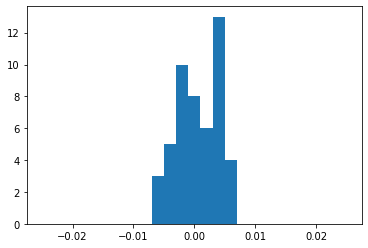

In [28]:
plt.hist(DF['x_f'],25,range=[-0.025,0.025]);

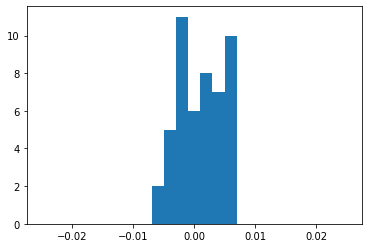

In [29]:
plt.hist(DF['y_f'],25,range=[-0.025,0.025]);

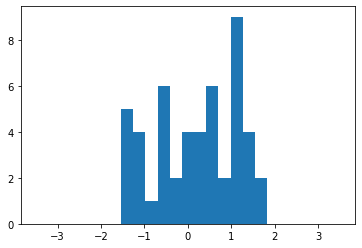

In [30]:
plt.hist(DF['vx_f'],25,range=[-3.5,3.5]);

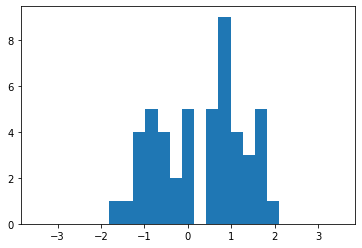

In [31]:
plt.hist(DF['vy_f'],25,range=[-3.5,3.5]);

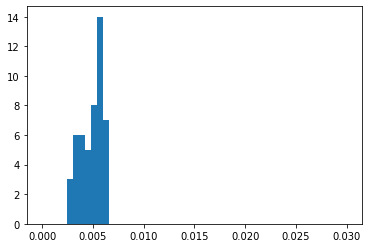

In [32]:
plt.hist((DF['x_f']**2+DF['y_f']**2)**0.5,50,range=[-0.0,0.03]);

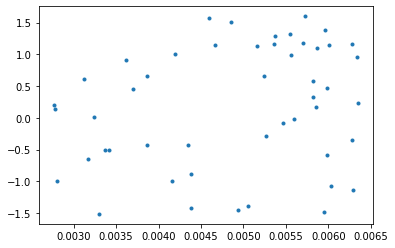

In [33]:
plt.scatter((DF['x_f']**2+DF['y_f']**2)**0.5,DF['vx_f'],marker='.')

In [34]:
#Now simulate the beam after Quad:
# assumming the ballistic motion from the end of Quad
#time for the beam to reach 100 cm from the end of Quad
#DF['vz_f'] = df2['vz']
#DF

In [35]:
DF['t_f1']=1.0/DF['vz_f']
DF

,x_f,vx_f,y_f,vy_f,vz_f,t_f1
0,0.004773,1.174491,0.003121,0.767636,219.698491,0.004552
1,0.003853,0.666527,0.000328,-0.076569,338.218652,0.002957
2,-0.005944,-1.488169,0.000330,-0.015284,180.561226,0.005538
3,0.003770,1.319232,-0.004076,-1.693093,319.204754,0.003133
4,-0.003299,-1.515015,0.000035,0.466678,365.176467,0.002738
5,0.002485,0.577226,0.005265,1.268084,149.384805,0.006694
6,-0.004697,-1.396980,-0.001868,-0.175101,252.335913,0.003963
7,0.002224,0.461753,0.002955,1.021696,221.317570,0.004518
8,0.002923,0.607127,-0.001108,-0.185258,270.022875,0.003703
9,-0.000801,0.012140,0.003145,0.801911,265.512121,0.003766


In [36]:
DF['x_f1']=DF['vx_f']*DF['t_f1']
DF['y_f1']=DF['vy_f']*DF['t_f1']
DF['r_f1']=(DF['x_f1']**2+DF['y_f1']**2)**0.5
DF

,x_f,vx_f,y_f,vy_f,vz_f,t_f1,x_f1,y_f1,r_f1
0,0.004773,1.174491,0.003121,0.767636,219.698491,0.004552,0.005346,0.003494,0.006386
1,0.003853,0.666527,0.000328,-0.076569,338.218652,0.002957,0.001971,-0.000226,0.001984
2,-0.005944,-1.488169,0.000330,-0.015284,180.561226,0.005538,-0.008242,-0.000085,0.008242
3,0.003770,1.319232,-0.004076,-1.693093,319.204754,0.003133,0.004133,-0.005304,0.006724
4,-0.003299,-1.515015,0.000035,0.466678,365.176467,0.002738,-0.004149,0.001278,0.004341
5,0.002485,0.577226,0.005265,1.268084,149.384805,0.006694,0.003864,0.008489,0.009327
6,-0.004697,-1.396980,-0.001868,-0.175101,252.335913,0.003963,-0.005536,-0.000694,0.005580
7,0.002224,0.461753,0.002955,1.021696,221.317570,0.004518,0.002086,0.004616,0.005066
8,0.002923,0.607127,-0.001108,-0.185258,270.022875,0.003703,0.002248,-0.000686,0.002351
9,-0.000801,0.012140,0.003145,0.801911,265.512121,0.003766,0.000046,0.003020,0.003021


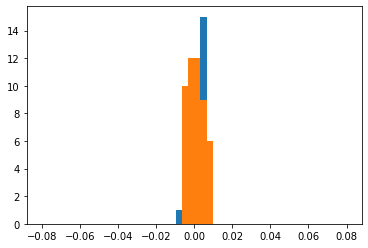

In [37]:
plt.hist(DF['x_f1'],50,range=[-0.08,0.08]);
plt.hist(DF['y_f1'],50,range=[-0.08,0.08]);

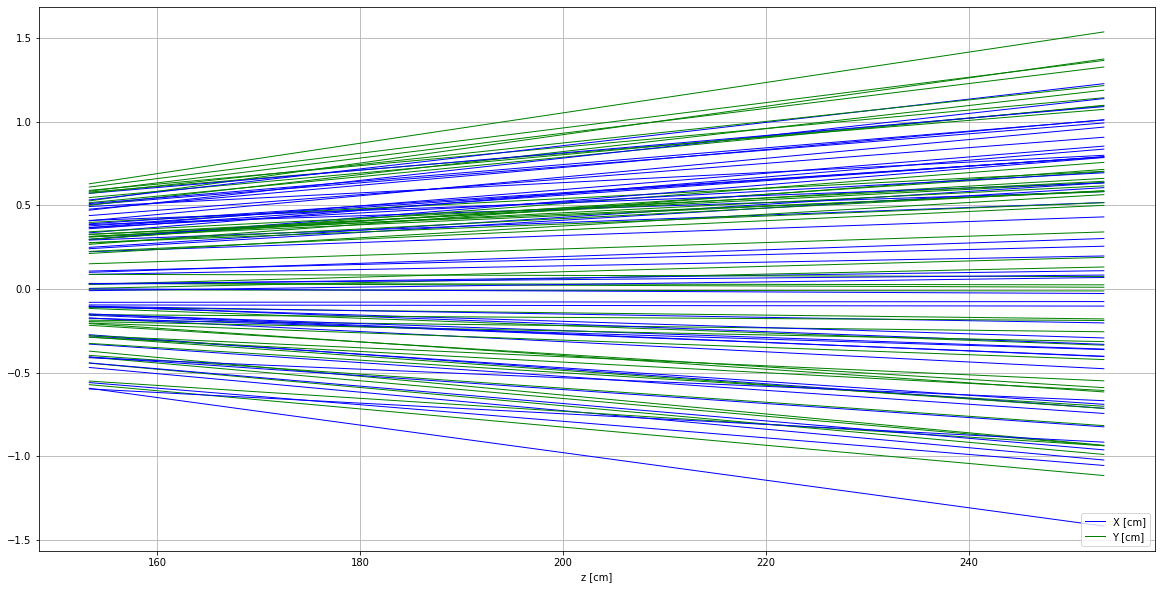

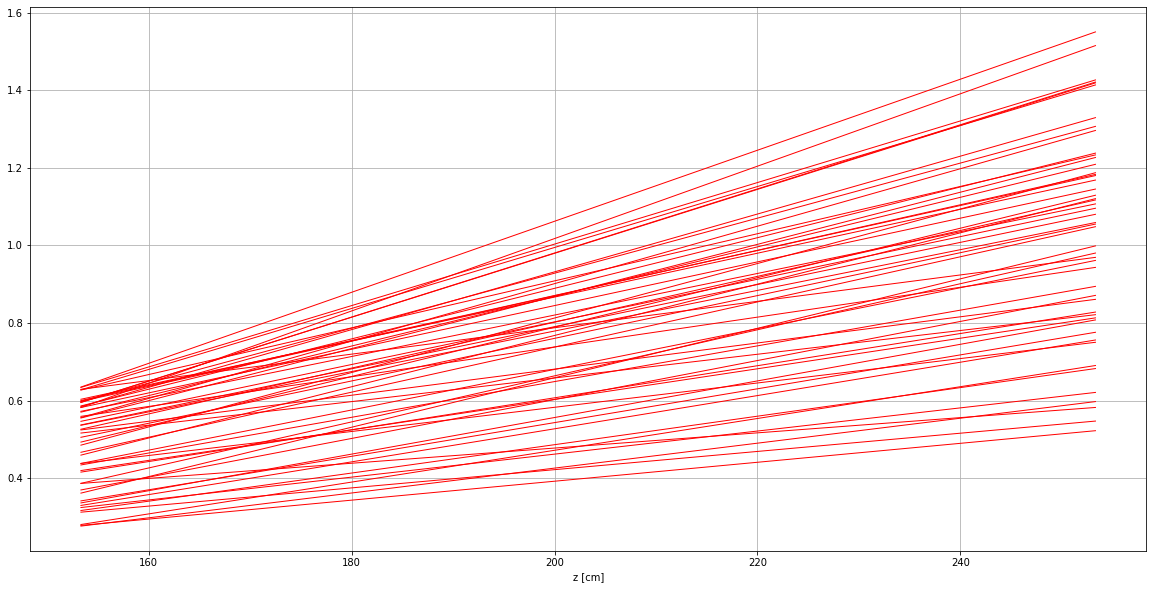

In [38]:
h=0;
for index, row in DF.iterrows():
    stoptime=row['t_f1']
    numpoints = 50

    #print(numpoints)
    t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]
    #print (t[0])
    #print(row['y_f'])
    Y_h=[]
    X_h=[]
    R_h=[]
    Z_h=[]
    for h_1 in range(numpoints):
        #print (h_1)
        y_h=(row['y_f']+row['vy_f']*t[h_1])*100
        x_h=(row['x_f']+row['vx_f']*t[h_1])*100
        z_h=row['vz_f']*t[h_1]*100+153.32167294
        r_h=(y_h**2+x_h**2)**0.5
        #print(y_h)
        Y_h.append(y_h)
        X_h.append(x_h)
        R_h.append(r_h)
        Z_h.append(z_h)
    #x_new=row['x_f']
    #vx_new=row['vx']
    #vy_new=row['vy']
    
    
    figure(3, figsize=(20, 10))
    xlabel('z [cm]')
    grid(True)
    #hold(True)
    lw = 1

    #plot(t, x1, 'b', linewidth=lw)
    #plot(t, x2, 'g', linewidth=lw)
    #plot(t, Y_h, 'b', linewidth=lw)
    plot(Z_h, X_h, 'b', linewidth=lw)
    plot(Z_h, Y_h, 'g', linewidth=lw)
    plt.legend(["X [cm]", "Y [cm]"], loc ="lower right")
    #plt.hist('R_h')
    
    figure(4, figsize=(20, 10))
    xlabel('z [cm]')
    grid(True)
    plot(Z_h, R_h, 'r', linewidth=lw)